In [2957]:
# MACD - Trend
# ATR - Volatility
# Bollinger Bands - Volatility
# RSI - Momentum
# ADX - trend
# OBV - volume
# MA50 - Trend
# MA20 - Trend

#To Do:
# Add more classes, weak buy, weak sell

# Final Project - Algorithmic Trading using machine learning methods

## Data Reading, Feature Engineering and Machine Learning

In [1]:
# Importing libraries
import time
import pandas as pd
import fxcmpy
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import ta
import numpy as np
import statsmodels.api as sm
import copy


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC

import pickle
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

C:\Users\saadv\Anaconda3\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


## 1. Data Reading

In [2]:
# Downloading data for the tickers for 15 minute timeframes
tickers = ["USOil", "EUR/USD", "SPX500", "XAU/USD"] #, "EUR/USD", "GBP/USD"
periods = "m15"
end = "2021-07-26"
start = "2021-01-01"
ohlc_m15 = {}

In [3]:
con = fxcmpy.fxcmpy(access_token="1212d102202fcb8bc84bdfa76a202c44e4d945df",log_level="error",server="demo")

In [2905]:
for ticker in tickers:
    ohlc_m15[ticker] = con.get_candles(instrument=ticker,period=periods, start=start,end=end) 
    ohlc_m15[ticker].dropna(inplace=True)
    ohlc_m15[ticker] = ohlc_m15[ticker].iloc[:,[0,1,2,3,8]]
    ohlc_m15[ticker].columns = ["Open","Close","High","Low","Volume"]


In [2907]:
ohlc_df = ohlc_m15.copy()

In [46]:
def candlebar(df1):
    df1.reset_index(inplace=True)
    df2 = df1.iloc[:,[0,1,3,4,2]]
    df2["date"]=df2["date"].apply(mpl_dates.date2num)


    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    candlestick_ohlc(ax,df2.values,width=0.5,colorup="green",colordown="red",alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d-%b-%Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.tight_layout()

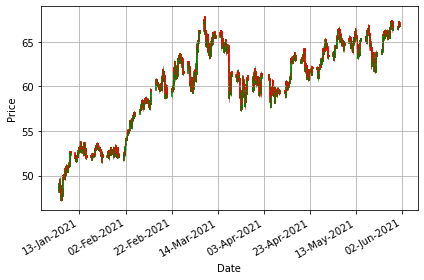

In [47]:
candlebar(ohlc_15m)

## 2. Data Preprocessing

In [3]:
def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [5]:
def features(df):
    """
    This function is to add all the required features to the dataset for ML models
    Absolute Return
    MACD -> Moving Average Convergence Divergence Indicator
    ATR -> Average true Range Indicator
    """
    df["Return_abs"] = df["Close"] - df["Open"]
    MACD_ta = ta.trend.MACD(df["Close"],window_fast=12,window_slow=26,window_sign=9,fillna=False)
    df["MACD_line"] = MACD_ta.macd()
    df["MACD_signal"] = MACD_ta.macd_signal()
    ATR_ta = ta.volatility.AverageTrueRange(high=df["High"],low=df["Low"],close=df["Close"],window=20,fillna=False)
    df["ATR"] = ATR_ta.average_true_range()
    indicator_bb = ta.volatility.BollingerBands(close=df["Close"],window=20,window_dev=2)
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()
    indicator_rsi = ta.momentum.RSIIndicator(close=df["Close"],window=14)
    df["RSI"] = indicator_rsi.rsi()
    indicator_adx = ta.trend.ADXIndicator(high=df["High"],low=df["Low"],close=df["Close"],window=14,fillna=False)
    df["ADX"] = indicator_adx.adx()
    indicator_obv = ta.volume.OnBalanceVolumeIndicator(close=df["Close"],volume=df["Volume"],fillna=False)
    df["OBV"] = indicator_obv.on_balance_volume()
    df["Slope_OBV_5"] = slope(df["OBV"],5)
    df["Slope_5"] = slope(df["Close"],5)
    df["Slope_100"] = slope(df["Close"],100)
    df["Slope_100"].replace(0,np.nan, inplace=True)
    df["Return_5"] = (df["Close"].shift(-5)/df["Close"]) - 1
    df["Return_4"] = (df["Close"].shift(-4)/df["Close"]) - 1
    df["Return_3"] = (df["Close"].shift(-3)/df["Close"]) - 1
    df["Return_2"] = (df["Close"].shift(-2)/df["Close"]) - 1
    df["Return_1"] = (df["Close"].shift(-1)/df["Close"]) - 1
    df.dropna(inplace=True)
    return df

In [ ]:
ohlc_df["EUR/USD"]

In [2908]:
df1 = {}
for ticker in tickers:
    df1[ticker] = features(ohlc_df[ticker])

C:\Users\saadv\Anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\saadv\Anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [2909]:
df1["USOil"]

,Open,Close,High,Low,Volume,Return_abs,MACD_line,MACD_signal,ATR,bb_bbm,...,ADX,OBV,Slope_OBV_5,Slope_5,Slope_100,Return_5,Return_4,Return_3,Return_2,Return_1
date,,,,,,,,,,,,,,,,,,,,,
2021-01-05 00:45:00,47.538,47.502,47.546,47.467,114,-0.036,-0.117779,-0.173382,0.185197,47.40730,...,31.298202,-6830,26.071843,42.747012,-38.608132,0.005200,0.004821,0.004168,0.004421,0.005347
2021-01-05 01:00:00,47.502,47.756,47.791,47.479,1063,0.254,-0.082551,-0.155216,0.191537,47.40460,...,30.182908,-5767,39.994652,41.085132,-39.159841,-0.000879,-0.000147,-0.000523,-0.001173,-0.000921
2021-01-05 01:15:00,47.756,47.712,47.797,47.648,583,-0.044,-0.057520,-0.135676,0.189410,47.41170,...,29.182680,-6350,36.039873,43.830861,-39.729746,0.000817,0.000042,0.000775,0.000398,-0.000252
2021-01-05 01:30:00,47.712,47.700,47.721,47.599,438,-0.012,-0.038210,-0.116183,0.186040,47.42220,...,27.845963,-6788,7.205935,40.061986,-40.316476,-0.000503,0.001069,0.000294,0.001027,0.000650
2021-01-05 01:45:00,47.700,47.731,47.753,47.654,334,0.031,-0.020173,-0.096981,0.181688,47.43180,...,26.818430,-6454,-5.779961,32.336709,-40.878234,-0.000126,-0.001152,0.000419,-0.000356,0.000377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23 20:30:00,72.079,72.059,72.092,72.029,231,-0.020,0.068570,0.065511,0.133916,71.97290,...,7.405781,272398,10.759804,39.658239,22.587478,0.002859,0.003289,0.002637,0.003358,0.003164
2021-07-25 22:00:00,72.150,72.287,72.310,72.050,537,0.137,0.085878,0.069584,0.140221,71.99955,...,9.463262,272935,36.575780,40.286392,19.363155,0.000484,-0.000304,0.000125,-0.000526,0.000194
2021-07-25 22:15:00,72.289,72.301,72.404,72.259,296,0.012,0.099577,0.075583,0.140460,72.01865,...,11.901629,273231,40.775305,47.792220,20.454805,0.000263,0.000290,-0.000498,-0.000069,-0.000719


## 3. Data Labelling

In [6]:
def MACD_sig(df):
    # Generating Buy and Sell signals for MACD indicator
    df["MACD_trade"] = "NoSignal"
    for i in range(len(df["MACD_line"])):
        if i > 0:
            if df["MACD_line"][i-1] < df["MACD_signal"][i-1]:
                if df["MACD_line"][i] > df["MACD_signal"][i]:
                    df["MACD_trade"][i] = "Buy"
            elif df["MACD_line"][i-1] > df["MACD_signal"][i-1]:
                if df["MACD_line"][i] < df["MACD_signal"][i]:
                    df["MACD_trade"][i] = "Sell"
        else:
            df["MACD_trade"][i] == "NoSignal"
    # Taking out consecutive buy signals
    df["MACD_trade_c"] = "NoSignal"
    for i in range(len(df["MACD_trade"])):
        if i == 0:
            df["MACD_trade_c"][i] = "NoSignal"
        elif df["MACD_trade"][i] == df["MACD_trade"][i-1] and i > 1:
            df["MACD_trade_c"][i] = "NoSignal"
        else:
            df["MACD_trade_c"][i] = df["MACD_trade"][i]
    return df[["MACD_trade","MACD_trade_c"]]

In [7]:
def bb_sig(df):
    # Generating Buy and Sell signals for bollinger bands indicator
    df["bb_trade"] = "NoSignal"
    for i in range(len(df["bb_bbm"])):
        if (df["Close"][i] > df["bb_bbl"][i] - df["ATR"][i]) and (df["Close"][i] < df["bb_bbl"][i] + df["ATR"][i]) and (df["Slope_100"][i] > 10):
            df["bb_trade"][i] = "Buy"
        elif (df["Close"][i] > df["bb_bbh"][i] - df["ATR"][i]) and (df["Close"][i] < df["bb_bbh"][i] + df["ATR"][i]) and (df["Slope_100"][i] < -10):
            df["bb_trade"][i] = "Sell"
    # Taking out consecutive buy signals
    df["bb_trade_c"] = "NoSignal"
    for i in range(len(df["bb_trade"])):
        if i == 0:
            df["bb_trade_c"][i] = "NoSignal"
        elif df["bb_trade"][i] == df["bb_trade"][i-1] and i > 1:
            df["bb_trade_c"][i] = "NoSignal"
        else:
            df["bb_trade_c"][i] = df["bb_trade"][i]
    return df[["bb_trade","bb_trade_c"]]

In [8]:
def other_sig(df):
    # RSI Trading Signal
    df["RSI_trade"] = "NoSignal"
    df.loc[df["RSI"] > 70,"RSI_trade"] = "Sell"
    df.loc[df["RSI"] < 30,"RSI_trade"] = "Buy"
    # ADX Trading Signal
    df["ADX_trade"] = "NoSignal"
    df.loc[(df["ADX"] > 30) & (df["Slope_100"] > 10),"ADX_trade"] = "Buy"
    df.loc[(df["ADX"] > 30) & (df["Slope_100"] < -10),"ADX_trade"] = "Sell"
    # OBV Trading Signal
    df["OBV_trade"] = "NoSignal"
    df.loc[(df["Slope_OBV_5"] > 10) & (df["Slope_100"] > 10),"OBV_trade"] = "Buy"
    df.loc[(df["Slope_OBV_5"] < -10) & (df["Slope_100"] < -10),"OBV_trade"] = "Sell"
    
    return df[["RSI_trade","ADX_trade","OBV_trade"]]

In [9]:
# try with additional slope 5, median return_5
# Clustering
# lowering the labels that is being predicted more
# Check SMOTE sampling
# PCA classification
# Check regression
# check regression with PCA
# timeseries 



# train every week once


def labels(df):
    # Label
    df["Label"] = "NoSignal"
    df.loc[(df["Slope_100"] > 10) & (((df["MACD_trade_c"] == "Buy") | (df["bb_trade_c"] == "Buy")) | ((df["RSI_trade"] == "Buy") | (df["ADX_trade"] == "Buy") | (df["OBV_trade"] == "Buy"))),"Label"] = "Buy"
    df.loc[(df["Slope_100"] < -10) & (((df["MACD_trade_c"] == "Sell") | (df["bb_trade_c"] == "Sell")) | ((df["RSI_trade"] == "Sell") | (df["ADX_trade"] == "Sell") | (df["OBV_trade"] == "Sell"))),"Label"] = "Sell"
    
    
    return df["Label"]

In [2915]:
for ticker in tickers:
    df1[ticker][["MACD_trade","MACD_trade_c"]] = MACD_sig(df1[ticker])
    df1[ticker][["bb_trade","bb_trade_c"]] = bb_sig(df1[ticker])
    df1[ticker][["RSI_trade","ADX_trade","OBV_trade"]] = other_sig(df1[ticker])
    df1[ticker]["Label"] = labels(df1[ticker])

C:\Users\saadv\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\saadv\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\saadv\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\saadv\Anaconda3\lib\site-packag

In [2917]:
df1["USOil"].groupby("Label").count()

,Open,Close,High,Low,Volume,Return_abs,MACD_line,MACD_signal,ATR,bb_bbm,...,Return_3,Return_2,Return_1,MACD_trade,MACD_trade_c,bb_trade,bb_trade_c,RSI_trade,ADX_trade,OBV_trade
Label,,,,,,,,,,,,,,,,,,,,,
Buy,4543,4543,4543,4543,4543,4543,4543,4543,4543,4543,...,4543,4543,4543,4543,4543,4543,4543,4543,4543,4543
NoSignal,5581,5581,5581,5581,5581,5581,5581,5581,5581,5581,...,5581,5581,5581,5581,5581,5581,5581,5581,5581,5581
Sell,2942,2942,2942,2942,2942,2942,2942,2942,2942,2942,...,2942,2942,2942,2942,2942,2942,2942,2942,2942,2942


## 5. Train Test Split

In [2918]:
Xtrain = {}
Xtest = {}
ytrain = {}
ytest = {}
for ticker in tickers:
    Xtrain[ticker] = df1[ticker][df1[ticker].index.month <= 5][["Volume","MACD_line","MACD_signal","ATR","bb_bbm","bb_bbh","bb_bbl","RSI","ADX","OBV",'Slope_5','Slope_100','Slope_OBV_5','Return_abs']]
    Xtest[ticker] = df1[ticker][df1[ticker].index.month > 5][["Volume","MACD_line","MACD_signal","ATR","bb_bbm","bb_bbh","bb_bbl","RSI","ADX","OBV",'Slope_5','Slope_100','Slope_OBV_5','Return_abs']]
    ytrain[ticker] = df1[ticker][df1[ticker].index.month <= 5]["Label"]
    ytest[ticker] = df1[ticker][df1[ticker].index.month > 5]["Label"]

## 6. Training the Base Model

In [2919]:
#Saving the model
for ticker in tickers:
    rf = RandomForestClassifier(n_estimators=60, max_depth=10, random_state=20)
    rf.fit(Xtrain[ticker],ytrain[ticker])
    binary = pickle.dumps(rf)
    ticks = ticker.replace("/","")
    open(f"rf_{ticks}.bin","wb").write(binary)

In [2943]:
rf_USOil = 0

In [11]:
for ticker in tickers:
    ticks = ticker.replace("/","")
    locals()["rf_"+str(ticks)] = pickle.loads(open(f"rf_{ticks}.bin","rb").read())  

In [2946]:
rf_USOil.score(Xtest["USOil"],ytest["USOil"])

0.9570345408593092

In [2927]:
tickers

['USOil', 'EUR/USD', 'SPX500', 'XAU/USD']

In [2947]:
ypred={}
ypred["USOil"] = rf_USOil.predict(Xtest["USOil"])
ypred["EUR/USD"] = rf_EURUSD.predict(Xtest["EUR/USD"])
ypred['SPX500'] = rf_SPX500.predict(Xtest['SPX500'])
ypred['XAU/USD'] = rf_XAUUSD.predict(Xtest['XAU/USD'])

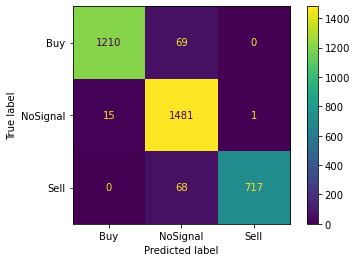

In [2948]:
conf = confusion_matrix(ytest["USOil"],ypred["USOil"])
plot_confusion_matrix(rf_USOil, Xtest["USOil"], ytest["USOil"], normalize=None)

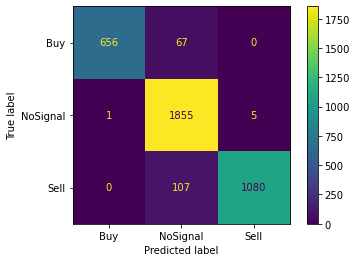

In [2949]:
conf = confusion_matrix(ytest["EUR/USD"],ypred["EUR/USD"])
plot_confusion_matrix(rf_EURUSD, Xtest["EUR/USD"], ytest["EUR/USD"], normalize=None)

## Return Calculations

In [10]:
# Calculating return of a trading strategy
def return_cal(df,label):
    return_cum = 0
    signal = ""
    price = 0
    ATR = 0
    for i in range(len(df[label])):
        # When the trade is Buy
        if df[label][i] == "Buy" and signal == "":
            return_cum += 0
            signal = "Buy"
            price = df["High"][i] # Previously was Close
            ATR = 1 * df["ATR"][i]
        elif signal == "Buy" and df["High"][i] <= (price + ATR) and df["Low"][i] >= (price - ATR):
            return_cum += df["Return_abs"][i]
        #Stop loss hit  
        elif signal == "Buy" and df["Low"][i] <= (price - 2*ATR):
            return_cum += df["Return_abs"][i]
            signal = ""
            price = 0
        #Take Profit Hit  
        elif signal == "Buy" and df["High"][i] >= (price + 1*ATR):
            return_cum += df["Return_abs"][i]
            signal = ""
            price = 0
        
        # when the trade is Sell        
        elif df[label][i] == "Sell" and signal== "":
            return_cum += 0
            signal = "Sell"
            price = df["Low"][i] # Previously was Close
            ATR = 1 * df["ATR"][i]
        elif signal == "Sell" and df["High"][i] <= (price + ATR) and df["Low"][i] >= (price - ATR):
            return_cum += -(df["Return_abs"][i])
        #Take Profit Hit
        elif signal == "Sell" and df["Low"][i] <= (price - 1*ATR):
            return_cum += -(df["Return_abs"][i])
            signal = ""
            price = 0
         #Stop loss hit
        elif signal == "Sell" and df["High"][i] >= (price + 2*ATR):
            return_cum += -(df["Return_abs"][i])
            signal = ""
            price = 0
            
    return return_cum

In [2950]:
test_pred = {}
for ticker in tickers:
    test_pred[ticker] = Xtest[ticker].copy()
    test_pred[ticker]["ytrue"] = ytest[ticker]
    test_pred[ticker]["ypredicted"] = ypred[ticker]
    test_pred[ticker][["Open","High","Low","Close"]] = df1[ticker][df1[ticker].index.month > 5][["Open","High","Low","Close"]]

In [2956]:
for ticker in tickers:
    true_return = round(return_cal(test_pred[ticker],"ytrue"),3)
    model_return = round(return_cal(test_pred[ticker],"ypredicted"),3)
    print(f"The {ticker} true return: {true_return} and model return: {model_return}")
    print("\n")
          

The USOil true return: 19.791 and model return: 21.869


The EUR/USD true return: 0.048 and model return: 0.046


The SPX500 true return: 369.57 and model return: 348.77


The XAU/USD true return: 186.55 and model return: 180.34




## 8. Model Training for start of every morning

In [11]:
def train_model(tickers, periods):
    "Running every morning to train the ML model on fresh data"
    for ticker in tickers:
        data = con.get_candles(instrument=ticker,period=periods,number=7000)
        data.dropna(inplace=True)
        ohlc = data.iloc[:,[0,1,2,3,8]]
        ohlc.columns = ["Open","Close","High","Low","Volume"]
        ohlc = features(ohlc)
        ohlc[["MACD_trade","MACD_trade_c"]] = MACD_sig(ohlc)
        ohlc[["bb_trade","bb_trade_c"]] = bb_sig(ohlc)
        ohlc[["RSI_trade","ADX_trade","OBV_trade"]] = other_sig(ohlc)
        ohlc["Label"] = labels(ohlc)
        Xtrain = ohlc[["Volume","MACD_line","MACD_signal","ATR","bb_bbm","bb_bbh","bb_bbl","RSI","ADX","OBV",'Slope_5','Slope_100','Slope_OBV_5','Return_abs']]
        ytrain = ohlc["Label"]
        rf = RandomForestClassifier(n_estimators=60, max_depth=10, random_state=20)
        rf.fit(Xtrain,ytrain)
        binary = pickle.dumps(rf)
        ticks = ticker.replace("/","")
        open(f"rf_{ticks}.bin","wb").write(binary)
        locals()["rf_"+str(ticks)] = pickle.loads(open(f"rf_{ticks}.bin","rb").read())  

In [12]:
train_model(tickers,periods)

## 9. Signal Generation on Live Data

In [13]:
def trade_signal(df,ticker,l_s,pl,g_pl):
    
    "function to generate trading signal on live data"
    signal = ""
    atr = 0
    price = 0
    Xpred = df[["Volume","MACD_line","MACD_signal","ATR","bb_bbm","bb_bbh","bb_bbl","RSI","ADX","OBV",'Slope_5','Slope_100','Slope_OBV_5','Return_abs']]
    signal_df = copy.deepcopy(Xpred)
    if l_s == "":
        if ticker == "USOil":
            rf_USOil = pickle.loads(open("rf_USOil.bin","rb").read())  
            signal = rf_USOil.predict(np.array(signal_df.iloc[-1,:]).reshape(1,-1))[0]
            if signal == "Buy" and df["bb_trade"].tolist()[-1] == "Buy":
                signal = "Buy"
            elif signal == "Sell" and df["bb_trade"].tolist()[-1] == "Sell":
                signal = "Sell"
            else:
                signal = "NoSignal"
            atr = df["ATR"].tolist()[-1]
            price = df["Close"].tolist()[-1]
                                   
        elif ticker == "EUR/USD":
            rf_EURUSD = pickle.loads(open("rf_EURUSD.bin","rb").read())
            signal = rf_EURUSD.predict(np.array(signal_df.iloc[-1,:]).reshape(1,-1))[0]
            if signal == "Buy" and df["bb_trade"].tolist()[-1] == "Buy":
                signal = "Buy"
            elif signal == "Sell" and df["bb_trade"].tolist()[-1] == "Sell":
                signal = "Sell"
            else:
                signal = "NoSignal"
            atr = df["ATR"].tolist()[-1]
            price = df["Close"].tolist()[-1]
            
        elif ticker == "SPX500":
            rf_SPX500 = pickle.loads(open("rf_SPX500.bin","rb").read())
            signal = rf_SPX500.predict(np.array(signal_df.iloc[-1,:]).reshape(1,-1))[0]
            if signal == "Buy" and df["bb_trade"].tolist()[-1] == "Buy":
                signal = "Buy"
            elif signal == "Sell" and df["bb_trade"].tolist()[-1] == "Sell":
                signal = "Sell"
            else:
                signal = "NoSignal"
            atr = df["ATR"].tolist()[-1]
            price = df["Close"].tolist()[-1]
            
        elif ticker == "XAU/USD":
            rf_XAUUSD = pickle.loads(open("rf_XAUUSD.bin","rb").read())
            signal = rf_XAUUSD.predict(np.array(signal_df.iloc[-1,:]).reshape(1,-1))[0]
            if signal == "Buy" and df["bb_trade"].tolist()[-1] == "Buy":
                signal = "Buy"
            elif signal == "Sell" and df["bb_trade"].tolist()[-1] == "Sell":
                signal = "Sell"
            else:
                signal = "NoSignal"
            atr = df["ATR"].tolist()[-1]
            price = df["Close"].tolist()[-1]
    
    elif l_s == "long":
        # take profit
        if  g_pl >= pl[ticker]:
            signal = "Close_long"
        
    
    elif l_s == "short":
        # take profit
        if g_pl >= pl[ticker]:
            signal = "Close_short"
        
        
    return signal,price,atr
        

## 9. Live Trading

In [14]:
# Downloading data for the tickers for 15 minute timeframes
tickers = ["USOil", "EUR/USD", "SPX500", "XAU/USD"] #, "EUR/USD", "GBP/USD"
periods = "m15"
amount = {"USOil": 8, "EUR/USD": 20, "SPX500": 3, "XAU/USD": 3}
profitloss = {"USOil": 5, "EUR/USD": 3, "SPX500": 5, "XAU/USD": 5}

In [16]:
def main():
    try:
        open_pos = con.get_open_positions()
        for ticker in tickers:
            long_short = ""
            entry_price = 0 # price at which the trade was entered
            exit_price = 0 # price at which will get out of trade
            stop_price = 0 # price at which will cut the loss
            gross_pl = 0 
            if len(open_pos) > 0:
                open_pos_cur = open_pos[open_pos["currency"]==ticker]
                if len(open_pos_cur) > 0:
                    if open_pos_cur["isBuy"].tolist()[0]==True:
                        long_short = "long"
                        exit_price = open_pos_cur.iloc[0]["limit"]
                        stop_price = open_pos_cur.iloc[0]["stop"]
                        entry_price = open_pos_cur.iloc[0]["open"]
                        gross_pl = open_pos_cur.iloc[0]["grossPL"]
                    elif open_pos_cur["isBuy"].tolist()[0]==False:
                        long_short = "short"
                        exit_price = open_pos_cur.iloc[0]["limit"]
                        stop_price = open_pos_cur.iloc[0]["stop"]
                        entry_price = open_pos_cur.iloc[0]["open"]
                        gross_pl = open_pos_cur.iloc[0]["grossPL"]
            # Getting data and training the model
            data = con.get_candles(instrument=ticker,period=periods,number=500)
            data.dropna(inplace=True)
            ohlc = data.iloc[:,[0,1,2,3,8]]
            ohlc.columns = ["Open","Close","High","Low","Volume"]
            ohlc = features(ohlc)
            ohlc[["bb_trade","bb_trade_c"]] = bb_sig(ohlc)
            signal, price, atr = trade_signal(ohlc,ticker,long_short,profitloss,gross_pl) 
            print("Currently at ticker: ", ticker, " || signal generated: ", signal, " || price: ", price)
            if signal == "Buy":
                con.open_trade(symbol=ticker, is_buy=True, is_in_pips=False, amount=amount[ticker], 
                               time_in_force='GTC', trailing_step = None, order_type='AtMarket')
                order_pos = con.get_open_positions()
                order_pos_cur = order_pos[order_pos["currency"]==ticker]
                con.change_trade_stop_limit(trade_id=order_pos_cur["tradeId"],is_stop=True,rate=(order_pos_cur["open"] - (2 * atr)),is_in_pips=False)
                con.change_trade_stop_limit(trade_id=order_pos_cur["tradeId"],is_stop=False,rate=(order_pos_cur["open"] + (1 * atr)),is_in_pips=False)
                print("New long position initiated for ", ticker, "at price: ", price, "with atr: ", atr)
            elif signal == "Sell":
                con.open_trade(symbol=ticker, is_buy=False, is_in_pips=False, amount=amount[ticker], 
                               time_in_force='GTC', trailing_step = None, order_type='AtMarket')
                order_pos = con.get_open_positions()
                order_pos_cur = order_pos[order_pos["currency"]==ticker]
                con.change_trade_stop_limit(trade_id=order_pos_cur["tradeId"],is_stop=True,rate=(order_pos_cur["open"] + (2 * atr)),is_in_pips=False)
                con.change_trade_stop_limit(trade_id=order_pos_cur["tradeId"],is_stop=False,rate=(order_pos_cur["open"] - (1 * atr)),is_in_pips=False)
                print("New short position initiated for ", ticker, "at price: ", price, "with atr: ", atr)
            elif signal == "Close_long" or signal == "Close_short" or signal == "Close_long_stoploss" or signal == "Close_short_stoploss":
                con.close_all_for_symbol(ticker)
                print(f"{signal} initiated for", ticker)
    except:
        print("error encountered....skipping this iteration")

In [17]:
# Continuous execution        
starttime=time.time()
timeout = time.time() + 60*60*1  # 60 seconds times 15 meaning the script will run for 15 mins
while time.time() <= timeout:
    try:
        print("passthrough at ",time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        main()
        time.sleep(600 - ((time.time() - starttime) % 600.0)) # 10 minute interval between each new execution
    except KeyboardInterrupt:
        print('\n\nKeyboard exception received. Exiting.')
        exit()

passthrough at  2021-08-03 15:19:35
Currently at ticker:  USOil  || signal generated:  NoSignal  || price:  70.849
Currently at ticker:  EUR/USD  || signal generated:  NoSignal  || price:  1.18839
Currently at ticker:  SPX500  || signal generated:  NoSignal  || price:  4401.49
Currently at ticker:  XAU/USD  || signal generated:  NoSignal  || price:  1808.53
passthrough at  2021-08-03 15:29:35
Currently at ticker:  USOil  || signal generated:  NoSignal  || price:  70.849
Currently at ticker:  EUR/USD  || signal generated:  NoSignal  || price:  1.18839
Currently at ticker:  SPX500  || signal generated:  NoSignal  || price:  4401.49
Currently at ticker:  XAU/USD  || signal generated:  NoSignal  || price:  1808.53


In [ ]:
# Close all positions and exit
for ticker in tickers:
    print("closing all positions for ",ticker)
    con.close_all_for_symbol(ticker)
con.close()

In [17]:
con.close()